<a href="https://colab.research.google.com/github/pullz6/ADS1-Visualisation/blob/main/Aircraft_Turbo_Defect_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install img2vec_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 899.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.8 MB/s eta 0:00:00


In [36]:
import pandas as pd
from img2vec_pytorch import Img2Vec
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Adding the images in.

In [37]:
train_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train',labels=None,image_size=(64,64),batch_size=32,color_mode='grayscale')
test_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/val',labels=None,image_size=(64,64), batch_size=32,color_mode='grayscale')

Found 257 files belonging to 1 classes.
Found 73 files belonging to 1 classes.


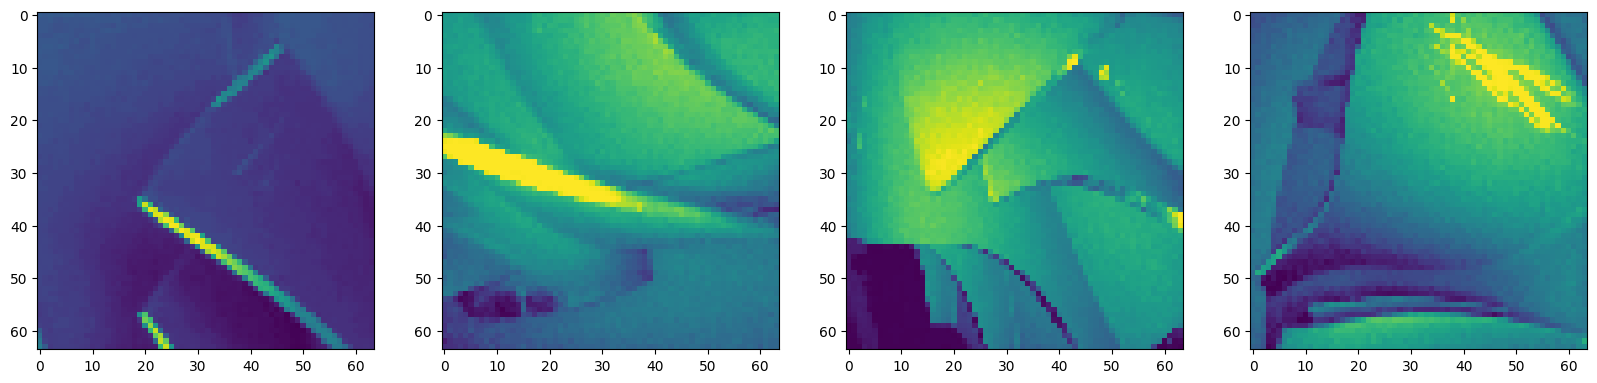

In [38]:
train_data_iterator = train_data.as_numpy_iterator()
batch = train_data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[:4]):
    ax[idx].imshow(img.astype(int))

In [41]:
name_train = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train')
name_val = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/val')

print("Names of the train images:", name_train)
print("Names of the validation images:", name_val)

Names of the train images: ['2023-04-06 19-36-30-341.jpg', '11_flip.jpg', '12.jpg', '12_3.jpg', '13_rot2.jpg', '12_rot3.jpg', '11_1.jpg', '10.jpg', '13.jpg', '12_1.jpg', '13_1.jpg', '13_rot1.jpg', '11_rot1.jpg', '13_2.jpg', '11_rot3.jpg', '13_4.jpg', '13_3.jpg', '10_rot1.jpg', '12_flip0.jpg', '12_rot2.jpg', '13_flip1.jpg', '12_2.jpg', '11_flip1.jpg', '11_2.jpg', '12_flip1.jpg', '1.jpg', '10_flip0.jpg', '11_flip0.jpg', '10_flip.jpg', '12_rot1.jpg', '13_rot3.jpg', '10_rot2.jpg', '13_flip.jpg', '13_flip0.jpg', '10_1.jpg', '12_flip.jpg', '11_rot2.jpg', '10_flip1.jpg', '10_rot3.jpg', '11.jpg', '15_2.jpg', '16_flip.jpg', '17_1.jpg', '18_rot2.jpg', '14.jpg', '18_flip0.jpg', '16_rot3.jpg', '16_rot1.jpg', '14_flip.jpg', '18_flip1.jpg', '15_1.jpg', '16_flip0.jpg', '18_2.jpg', '15_3.jpg', '14_rot1.jpg', '17.jpg', '14_flip1.jpg', '15_rot3.jpg', '17_rot2.jpg', '14_flip0.jpg', '17_4.jpg', '18_1.jpg', '14_rot3.jpg', '16.jpg', '15_flip.jpg', '17_3.jpg', '15_rot2.jpg', '15.jpg', '17_flip1.jpg', '17_fli

Reading the category and the location of the data in the labels file

In [42]:
# Folder Path
path = "/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train"

# Change the directory
os.chdir(path)

def read_text_file(file_path):
    with open(file_path, 'r') as f:
        print(f.read())

# iterate through all file
for file in os.listdir():
    # Check whether file is in text format or not
    if file.endswith(".txt"):
        file_path = f"{path}\{file}"

        # call read text file function
        read_text_file(file_path)